## Introduction to Large-Scale Network Analysis with Pyspark and Graphframe

## Background

This tutorial provides an introduction on how to conduct large-scale network analysis using Spark and graphframe. This tutorial will focus on basic features of Pyspark SQL that can be applied toward computation on large graph. Features of graphframe (a package in Spark that focuses on graph-related computation) will also be introduced. 

Before we proceed to the rest of this tutorial, I will provide some background of Spark. Spark is a computing framework developed by Apache Foundation in 2013 to overcome some shortcoming of Apache Hadoop MapReduce. General pipeline of MapReduce is as follow: apply function to some data on disk and assign a key (map), group data by batch and distribute batches of data to computing nodes (shuffle), aggregate the batch of data to a single result (reduce) and store on Disk. This process is slow as it relies on disk operation (streaming batch of data to individual computing node and reading into disk for further computing job) and somewhat cumbersome (for each computing job, a mapper and reducer has to be provided). Spark is faster than the Hadoop MapReduce for most of the computing tasks as it is optimized for such computation. Also, since the introduction of Data Frame and Spark SQL since Spark 1.6, such cumbersomeness will also be alleviated as some of the computing jobs can be expressed in SQL expressions. For example, a simple word count program can be done by just `wordDF.groupby('word').count()` given all words are parsed and stored in a data frame called `wordDF` with column `word`. 

## Setting up Environment and IO
After a rough introduction of Spark, we will begin the tutorial by setting up Spark Environment. Spark has api for Scala, Python, and R. For this tutorial, I will use Spark's api for Python, which is Pyspark. Installing Pyspark is easy as it is available in PyPi. To install, just type `pip install pyspark` in your shell, as it will automatically install the dependency and add pyspark in the `PATH`. For installation of other api, I suggest reading https://spark.apache.org/downloads.html for downloads and installation. 

To test whether Spark is properly installed, type `pyspark` in your shell. If you see the following message pop up in your shell:
``` shell
Welcome to
      ____              __
     / __/__  ___ _____/ /__
    _\ \/ _ \/ _ `/ __/  '_/
   /__ / .__/\_,_/_/ /_/\_\   version 2.4.0
      /_/

Using Python version 3.7.0 (default, Jun 28 2018 13:15:42)
SparkSession available as 'spark'.
```
Then you have pyspark correctly installed and configured.

After installing pyspark, we will first run Spark in local mode. To use Spark, we will need an entry point. Such entry point will be a `SparkSession` object (given that we deal mostly with DataFrames). Note that in the above shell message, a default `SparkSession` object is created as `spark`. Now, we will show how to create one `SparkSession` with desired configuration. 

In [2]:
from pyspark.sql import SparkSession
from pyspark import SparkConf
# Create configuration for Spark Session
conf = SparkConf() \
    .setAll([('spark.sql.execution.arrow.enabled', True)])

# Create a spark session
demo = SparkSession.builder.config(conf=conf).getOrCreate()

In the code snippet above, note that we add in the key-value pair `('spark.sql.execution.arrow.enabled', True)` into our Spark config. Apache Arrow is a standardized in-memory data storage format. A noticeable feature of Arrow is that it is language-independent. As the data are stored in memory in Arrow format, there is no conversion overhead for data transferring between python and Spark. This configuration is also essential to our next steps, as it enables the use of pandas udf (pandas user defined function). 

After installing Pyspark, let's try creating some DataFrames in Spark. Pyspark SQL accepts multiple formats of input, such as csv, json, pandas, parquet, etc. We will try reading data from parquet format. Parquet is a columnar, binary storage format. It is the on-disk storage format for the Arrow format we mentioned above. We can convert a csv/txt file to a parquet file by first converting it to a pandas dataframe and then convert it to parquet. The following code snippet describe the steps of converting a text file to a parquet file:

In [ ]:
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq

# Read from csv to create a pandas data frame
edges_pd = pd.read_csv('edges.csv', columns = ['src', 'dst'])
edges_pd.to_parquet('data/edges.parquet', index=False)

Now, we should have a file named `edges.parquet` with column `src` and `dst` in a directory `data` (Create one beforehand if you don't have one already). Now, let's try reading this parquet file into our current Spark Session as a data.frame and see what it looks like.

In [3]:
edges_df = demo.read.parquet('data/edges.parquet')
edges_df.show(10)

+----+---+
| src|dst|
+----+---+
| -35| 27|
| -28|263|
|-165|100|
| -26|263|
| -65|134|
| -26|134|
| -65| 90|
|-144| 75|
|-732|242|
|-249|475|
+----+---+
only showing top 10 rows



## Pyspark SQL and Pandas UDF
After we load our `edges` dataframe into our Spark session, we shall now exlpore more features of the pyspark sql. Since the first data frame `edges` is in the form of an adjacency list, we can do some very basic graphic EDA using SQL. Now suppose that all positive number in the `edges` data frame is a GitHub user's ID, while every negative number represents the ID of a GitHub repository. Then each row in our `edges` table represents an edge from `src` to `dst` in this simple graph. Next, we want to know what are the indegrees and outdegrees of repositories on GitHub. It turns out that it is quite easy to do so with Spark SQL. All we need is three table operations: `filter()`, `groupby()`, and `count()`. Let's take the calculation of indegree of repositories as an example:

In [4]:
import pyspark.sql.functions as F
repo_indegree = edges_df.filter('dst < 0') \
    .groupby('dst') \
    .count() \
    .withColumnRenamed('dst', 'id') \
    .withColumnRenamed('count', 'indegree').cache()
repo_indegree.show(10)

+------+--------+
|    id|indegree|
+------+--------+
|  -882|       1|
| -1299|       1|
| -3150|       1|
| -4657|       1|
| -8001|       9|
| -8659|       5|
|-10751|       1|
|-10798|       1|
|-12237|      20|
|-16813|       8|
+------+--------+
only showing top 10 rows



Now, we will break down the above code snippet. First, we filter out the entries where the destination positive (only keeping negative number which represents the repositories). Next, we group by the destination nodes and aggregate each grouped data by counting the number of rows in each group. Using this `repo_indegree ` table, we can check the degree distribtion of GitHub's repo's contribution. Using the function `approxQuantile` provided in pyspark.sql, we can calculate the approximate empirical cdf of the indegree for the repositories on GitHub. 

/home/rgan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log10
  # This is added back by InteractiveShellApp.init_path()


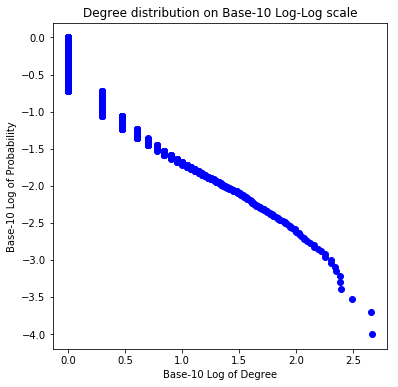

In [7]:
import matplotlib.pyplot as plt
import numpy as np


samp_probs = np.linspace(1e-4, 1, int(1e4)).tolist()
degree_quantile = repo_indegree.stat \
            .approxQuantile(col='inDegree',
                            probabilities=samp_probs,
                            relativeError=1e-4)
plt.figure(figsize=(6, 6))
plt.plot(np.log10(degree_quantile),
         np.log10([1 - i for i in samp_probs]),
                'bo')
plt.xlabel('Base-10 Log of Degree')
plt.ylabel('Base-10 Log of Probability')
plt.title('Degree distribution on Base-10 Log-Log scale')
plt.show()

Although pyspark.sql.functions provide a wide range of function library, in some cases we may find that none of the function provided fits our need. For example, in our following graphframe example, we want to have an aggregate function that returns most frequent item within a list, and if there are ties, choose uniformly random on the set of most frequent items. The existed spark sql function library doesn't seem to have such function. Now, we will need the help of Pandas UDF (User defined function). Pandas UDF allows you to defined your own operation on column(s) of data frame. There are three For a thorough tutorial on these function

## Graphframe

## Message Passing